Let's explore the crime data for the Chicago CTA, specifically the train lines

In [82]:
# Helper modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd

#data parsing
from urllib.parse import urlencode
import duckdb as db

#stats and modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [83]:
#first we'll pull only the CTA related crime data out of the Crimes - 2001 to Present dataset from the City of Chicago Data Portal since it is too large to load the full thing
BASE_URL = "https://data.cityofchicago.org/resource/ijzp-q8t2.csv"

#we'll filter for "CTA PLATFORM". "CTA TRAIN", or "CTA STATION"
match_list = ['CTA PLATFORM', 'CTA TRAIN', 'CTA STATION']

#we'll use duckdb to query and push the filter onto the server to limit downloaded data
# Create a DuckDB connection (in-memory)
con = db.connect()

# make it a SQL readable list
def escape_soql(v): return "'" + v.replace("'", "''") + "'"
in_list = ",".join(escape_soql(v) for v in match_list)
#build the query
where = f"location_description in ({in_list})"
params = {"$where": where, "$limit": 500000}
url = f"{BASE_URL}?{urlencode(params, safe='(), ')}"

df = con.execute(
    "INSTALL httpfs; LOAD httpfs; SELECT * FROM read_csv_auto(?, HEADER=TRUE)", 
    [url]).fetchdf()
#cleanup
con.close()

df.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,13951257,JJ395683,2025-08-30 17:52:00,001XX W LAKE ST,2022,NARCOTICS,POSSESS - COCAINE,CTA STATION,True,False,0122,001,42,32,18,1175301,1901735,2025,2025-09-07 15:57:31,41.885741,-87.631712,"\n, \n(41.885741029, -87.631711749)"
1,13951756,JJ396124,2025-08-30 13:15:00,009XX W LAKE ST,031A,ROBBERY,ARMED - HANDGUN,CTA PLATFORM,False,False,1214,012,27,28,03,1169909,1901639,2025,2025-09-07 15:57:31,41.885597,-87.651515,"\n, \n(41.885596865, -87.651514924)"
2,13950979,JJ395228,2025-08-30 10:47:00,051XX S PULASKI RD,0560,ASSAULT,SIMPLE,CTA STATION,False,False,0815,008,23,62,08A,1150563,1870470,2025,2025-09-07 15:57:31,41.800465,-87.723370,"\n, \n(41.800464977, -87.723370404)"
3,13950712,JJ394972,2025-08-30 03:15:00,001XX W CERMAK RD,0312,ROBBERY,ARMED - KNIFE / CUTTING INSTRUMENT,CTA TRAIN,False,False,0914,009,11,34,03,1175616,1889758,2025,2025-09-07 15:57:31,41.852868,-87.630915,"\n, \n(41.852868298, -87.63091491)"
4,13950839,JJ395061,2025-08-30 01:47:00,016XX N DAMEN AVE,0810,THEFT,OVER $500,CTA TRAIN,False,False,1434,014,32,24,06,1162771,1910740,2025,2025-09-07 15:57:31,41.910723,-87.677471,"\n, \n(41.910723346, -87.677471499)"


In [84]:
print(df.shape)
#check that there are no duplicate entries
print(df['case_number'].nunique())

# convert to GeoDataFrame (requires Latitude and Longitude)
cta_crimes = df.dropna(subset=["latitude", "longitude"])
print(cta_crimes.shape)


(83545, 22)
83545
(82908, 22)


Okay, so about 600 cases didn't list the latitude and longitude. For this case, we still have enough to analyze as a cleaner dataset.

In [85]:
geometry = [Point(xy) for xy in zip(cta_crimes["longitude"], cta_crimes["latitude"])]
gdf_cta = gpd.GeoDataFrame(cta_crimes, geometry=geometry, crs="EPSG:4326")

gdf_cta.head()


,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,geometry
0,13951257,JJ395683,2025-08-30 17:52:00,001XX W LAKE ST,2022,NARCOTICS,POSSESS - COCAINE,CTA STATION,True,False,0122,001,42,32,18,1175301,1901735,2025,2025-09-07 15:57:31,41.885741,-87.631712,"\n, \n(41.885741029, -87.631711749)",POINT (-87.63171 41.88574)
1,13951756,JJ396124,2025-08-30 13:15:00,009XX W LAKE ST,031A,ROBBERY,ARMED - HANDGUN,CTA PLATFORM,False,False,1214,012,27,28,03,1169909,1901639,2025,2025-09-07 15:57:31,41.885597,-87.651515,"\n, \n(41.885596865, -87.651514924)",POINT (-87.65151 41.8856)
2,13950979,JJ395228,2025-08-30 10:47:00,051XX S PULASKI RD,0560,ASSAULT,SIMPLE,CTA STATION,False,False,0815,008,23,62,08A,1150563,1870470,2025,2025-09-07 15:57:31,41.800465,-87.723370,"\n, \n(41.800464977, -87.723370404)",POINT (-87.72337 41.80046)
3,13950712,JJ394972,2025-08-30 03:15:00,001XX W CERMAK RD,0312,ROBBERY,ARMED - KNIFE / CUTTING INSTRUMENT,CTA TRAIN,False,False,0914,009,11,34,03,1175616,1889758,2025,2025-09-07 15:57:31,41.852868,-87.630915,"\n, \n(41.852868298, -87.63091491)",POINT (-87.63091 41.85287)
4,13950839,JJ395061,2025-08-30 01:47:00,016XX N DAMEN AVE,0810,THEFT,OVER $500,CTA TRAIN,False,False,1434,014,32,24,06,1162771,1910740,2025,2025-09-07 15:57:31,41.910723,-87.677471,"\n, \n(41.910723346, -87.677471499)",POINT (-87.67747 41.91072)


In [86]:
# Classify Crimes as Violent vs Petty 
violent_crimes = [
    "HOMICIDE", "CRIMINAL SEXUAL ASSAULT", "ROBBERY", "BATTERY",
    "ASSAULT", "SEX OFFENSE", "KIDNAPPING", "HUMAN TRAFFICKING"
]

def crime_category(primary_type):
    if primary_type.upper() in violent_crimes:
        return "Violent"
    else:
        return "Petty"

gdf_cta["crime_category"] = gdf_cta["primary_type"].apply(crime_category)
gdf_cta["crime_category"].value_counts()


crime_category
Petty      59376
Violent    23532
Name: count, dtype: int64

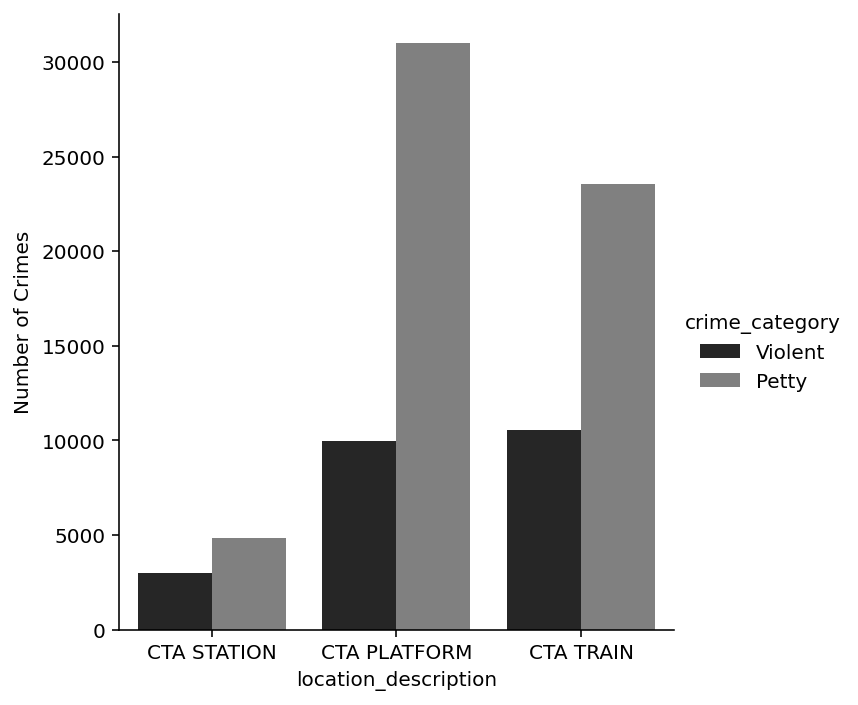

In [87]:
sns.catplot(data=gdf_cta, kind='count', x='location_description',hue='crime_category',palette='dark:grey',hue_order=['Violent','Petty'])
plt.ylabel("Number of Crimes")
plt.show()

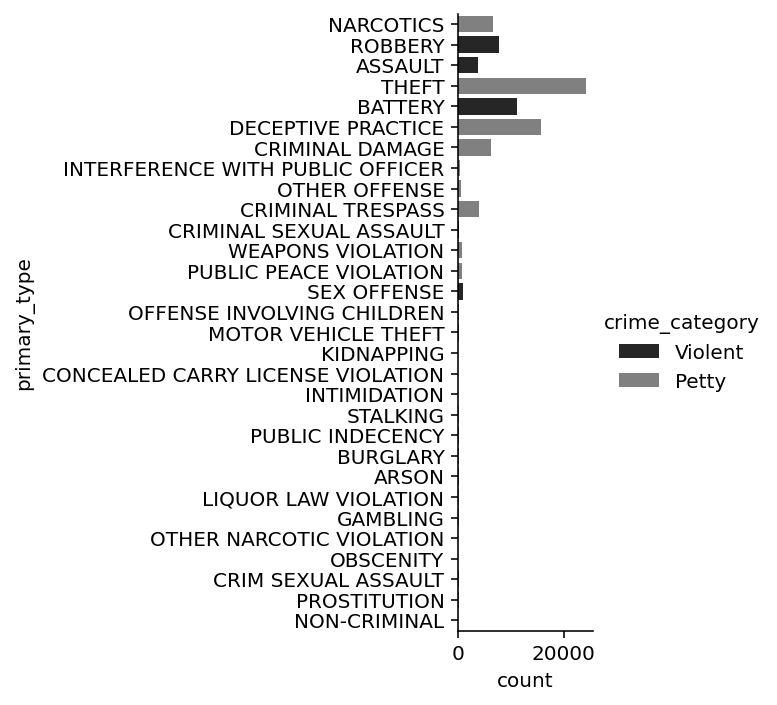

In [88]:
sns.catplot(data=gdf_cta, kind='count', y='primary_type',hue='crime_category',palette='dark:grey',hue_order=['Violent','Petty'])
plt.show()

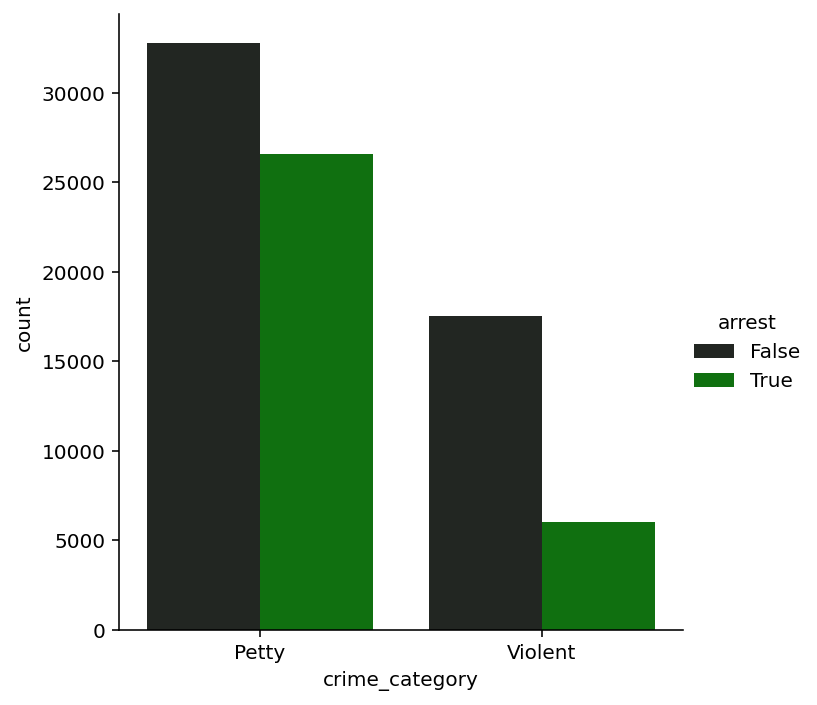

In [89]:
sns.catplot(data=gdf_cta, kind='count', x='crime_category',hue='arrest',palette='dark:green')
plt.show()

In [90]:
gdf_cta[['crime_category','arrest']].groupby('crime_category').mean()

,arrest
crime_category,
Petty,0.447875
Violent,0.254632


Somewhat surprising that closer to half of the Petty crimes lead to an arrest while only a quarter of the Violent ones did.

Let's see if time of day has any impact by looking at the commuting/rush hours. The CTA considers the peak commuting windows to be 7–9 AM and 4–6 PM

In [91]:
# Month as integer 1..12 pulled from Date
gdf_cta["month"] = gdf_cta["date"].dt.month.astype("Int64")

#Classify commuting rush periods and non-commuting times 
h = gdf_cta["date"].dt.hour
commute_mask = ((h >= 7) & (h < 9)) | ((h >= 16) & (h < 18))
gdf_cta["commuting"] = commute_mask.astype("int8")   # 1=in commute window, 0 otherwise
gdf_cta["commuting"].value_counts()

commuting
0    64627
1    18281
Name: count, dtype: int64

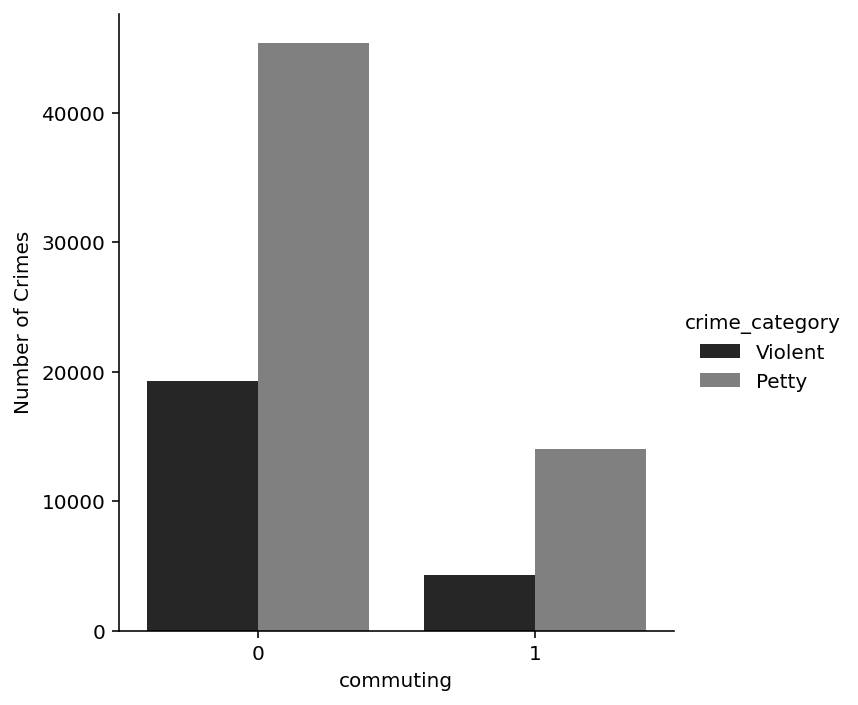

In [92]:
sns.catplot(data=gdf_cta, kind='count', x='commuting',hue='crime_category',palette='dark:grey',hue_order=['Violent','Petty'])
plt.ylabel("Number of Crimes")
plt.show()

Okay, so we do see signicicantly less events during the commuting window but this isn't truly representative because commuting hours are only ~4hrs out of the day. Still, it is interesting to see that there are overall fewer events during the commuting hours which aligns with the local perception of relative safety in numbers. But let's see if this holds up...

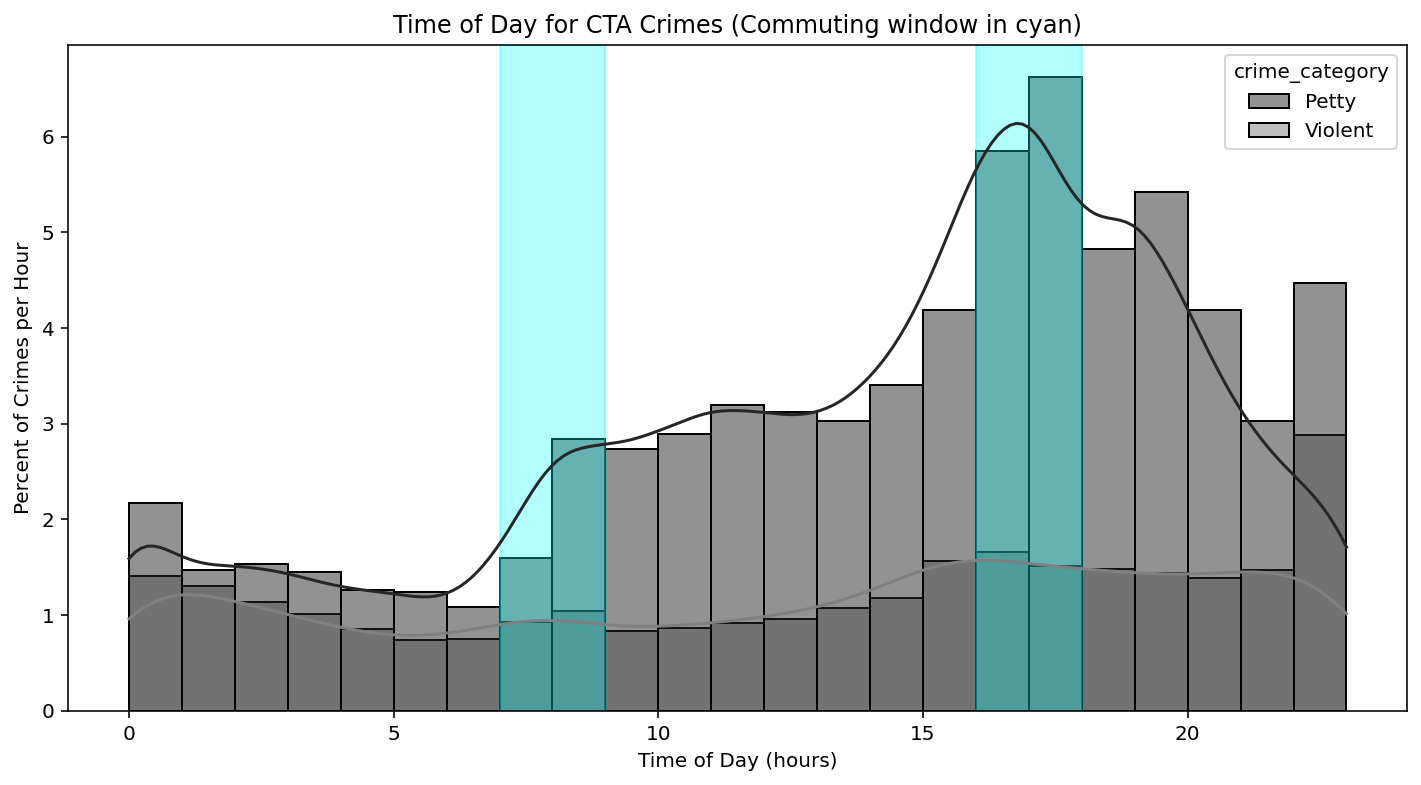

In [93]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=gdf_cta, x=gdf_cta['date'].dt.hour,hue='crime_category', binwidth=1,palette='dark:grey', stat='percent', kde=True) 

# shade the commuting windows on the plot
ax.axvspan(7, 9, color='cyan', alpha=0.3, label='Commuting')
ax.axvspan(16, 18, color='cyan', alpha=0.3, label='Commuting')

plt.ylabel("Percent of Crimes per Hour")
plt.xlabel("Time of Day (hours)")
plt.title('Time of Day for CTA Crimes (Commuting window in cyan)')
plt.show()

Okay, so if we only looked at the total crimes during commuting hours, then things would look pretty good for the 'safety in number hypothesis'. However, we see a spike in the total events during both the evening rush hours and a big jump in the 8AM bin as well. Again, this may still be skewed because the total number of riders is spiking then also but overall the commuting windows contain almost a third of the crime events.

In [94]:
print(pd.crosstab(gdf_cta["commuting"], gdf_cta['crime_category'], normalize = True))


crime_category     Petty   Violent
commuting                         
0               0.547076  0.232426
1               0.169091  0.051406


It almost looks like the proportion of Petty to Violent crimes is the same in both windows but let's test the hypothesis that the frequency and category of crimes is lower in the commuting window. We are looking at count data, so we will use a Poisson distribution.

In [95]:
df_commute_test = (gdf_cta.groupby(["year", "month","commuting","crime_category"], as_index=False)
      .agg(count=('crime_category', 'size')))

f = "count ~ month + C(commuting) * C(crime_category)"

# Fit Poisson GLM with log link and offset
model = smf.glm(formula=f, data=df_commute_test,
                family=sm.families.Poisson())
res = model.fit(cov_type="HAC", cov_kwds={"maxlags": 12})  # monthly HAC

res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                 1184
Model:                            GLM   Df Residuals:                     1179
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9499.1
Date:                Mon, 08 Sep 2025   Deviance:                       12266.
Time:                        20:15:02   Pearson chi2:                 1.18e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HAC                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          5.0507      0.048    104.470      0.000       4.956       5.145
C(commuting)[T.1]                                 -1.1742      0.032    -37.207      0.000      -1.236      -1.112
C(crime_category)[T.Violent]                      -0.8560      0.055    -15.495      0.000      -0.964      -0.748
C(commuting)[T.1]:C(crime_category)[T.Violent]    -0.3347      0.035     -9.550      0.000      -0.403      -0.266
month                                             -0.0029      0.005     -0.545      0.586      -0.013       0.008
==================================================================================================================
"""

Interesting... Let's confirm the fit of the model before we interpret.

In [96]:

from statsmodels.graphics.tsaplots import plot_acf
def poisson_diagnostics(res, df=None, maxlags=24, title_prefix="Poisson GLM"):
    """
    res: fitted statsmodels GLMResults (family=Poisson)
    df:  original DataFrame used to fit (optional; needed if you want ACF by time order)
    maxlags: for ACF
    """

    # --- Core residuals / fitted ---
    fitted = res.fittedvalues
    resid_resp = res.resid_response              # y - mu_hat
    resid_pear = res.resid_pearson               # Pearson residuals
    resid_dev  = res.resid_deviance              # Deviance residuals

    # Quick dispersion check (Pearson)
    pearson_chi2 = np.sum(resid_pear**2)
    dispersion = pearson_chi2 / res.df_resid

    print(f"{title_prefix} — Pearson dispersion ≈ {dispersion:.2f} "
          f"(Pearson χ² / df_resid = {pearson_chi2:.1f} / {res.df_resid})")

    # Residuals vs fitted (Pearson)
    plt.figure(figsize=(7,4))
    plt.scatter(fitted, resid_pear, s=12)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Pearson residuals")
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.tight_layout()
    plt.show()

    # QQ-plot of deviance residuals (should be ~N(0,1) if model fits well)
    plt.figure(figsize=(7,4))
    sm.qqplot(resid_dev, line="45", fit=True)
    plt.title(f"{title_prefix}: QQ-plot (Deviance residuals)")
    plt.tight_layout()
    plt.show()


Poisson GLM — Pearson dispersion ≈ 10.00 (Pearson χ² / df_resid = 11787.1 / 1179)


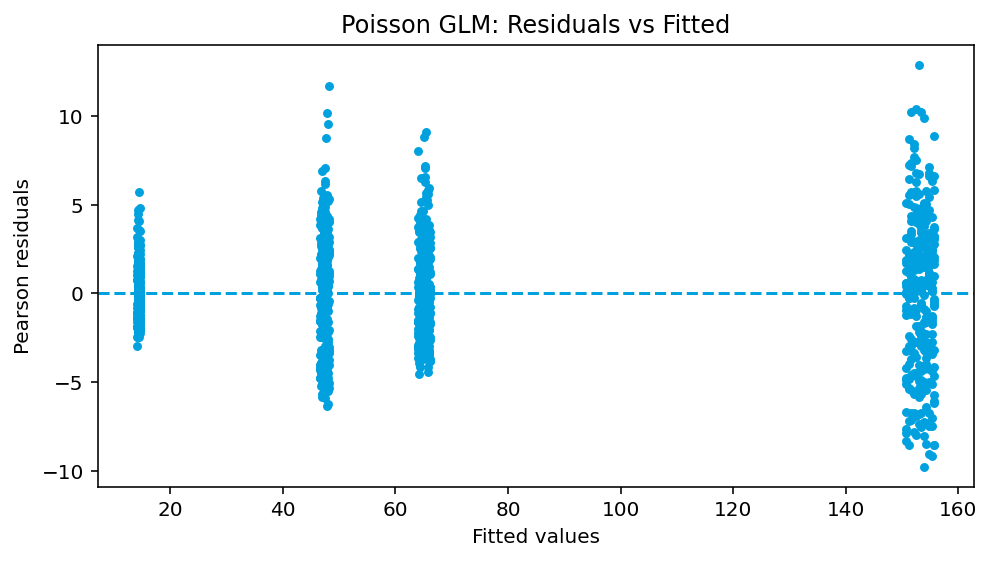

<Figure size 1008x576 with 0 Axes>

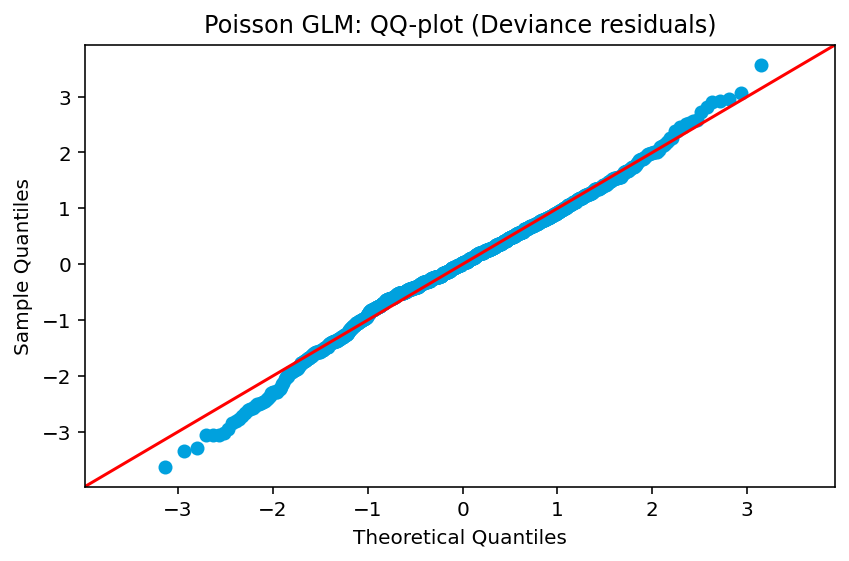

In [97]:

poisson_diagnostics(res, df=df_commute_test)

We're modeling 2 categorical variables with Month thrown in there to add a continuous option as well as to test for overt seasonal impacts, so the fitted values being clustered is not surprising. The good thing is that they are centered around 0 and the Q-Qplot is linear and doesn't have significant devations. Okay, so now we can interpret the model results...

So our first question: Are crimes less likely during commuting windows?
- Commuting vs. non-commuting (among non-violent): RR = 0.309 (0.291–0.329), p<0.001. So, yes expected counts were about 69% lower during commuting times.

Second question: Are Violent crimes less likely during the commuting windows?
- Interaction: RR = 0.715 (0.667–0.766), p<0.001. So the violent vs. non-violent gap is larger during commuting, and the expected count of Violent events is ~28% lower during commuting periods vs non-commuting, and non-violent crime events.

This would be more meaningful as a rate or likeihood based on ridership but we only have access to monthly ridership data so this will have to do for now.


Okay, now let's see if these events are localized to specific lines or areas and then add in ridership data per line to start to look at the rate of crime.

In [98]:
# load Chicago Neighborhood Boundaries
# https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9
gdf_neigh = gpd.read_file("data/Neighborhoods_2012b_20250830.geojson").to_crs(epsg=4326)

# load CTA Routes 
# https://data.cityofchicago.org/Transportation/CTA-L-Rail-Lines-Shapefile/53r7-y88m/about_data
gdf_routes = gpd.read_file("data/CTA_-_'L'_(Rail)_Stations_20250830.geojson").to_crs(epsg=4326)


In [99]:
import re
# CTA color map to match the rail line names
CTA_ORDER = ["BLUE","BROWN","GREEN","MULTIPLE","ORANGE","PINK","PURPLE","RED","YELLOW"]
# TOKENS = ["RED","BLUE","BROWN","GREEN","ORANGE","PURPLE","PINK","YELLOW"]
CTA_COLORS = {
    "BLUE":   "#00A1DE",
    "BROWN":  "#62361B",
    "GREEN":  "#009B3A",
    "MULTIPLE":"#666666",
    "ORANGE": "#F9461C",
    "PURPLE": "#522398",
    "PINK":   "#E27EA6",
    "RED":    "#C60C30",
    "YELLOW": "#F9E300",
}
# Choose the global cycle order (the sequence plots will use by default)
cta_palette = sns.set_palette([CTA_COLORS[k] for k in CTA_ORDER])

# contains (case-insensitive) with word boundaries to avoid
def first_token(s: str) -> str:
    s = "" if s is None else str(s)
    for t in CTA_ORDER:
        if re.search(rf"\b{t}\b", s, flags=re.I):
            return t
    return "OTHER"
#Purple line isn't ever listed as it's own so we'll modify the legend to be more specific
gdf_routes.loc[gdf_routes['lines']=='Purple Line, Evanston Express','legend'] = 'Purple Line'

gdf_routes["line_color"] = gdf_routes["legend"].map(first_token)
gdf_routes["color"] = gdf_routes["line_color"].map(CTA_COLORS).fillna("#666666")  # gray fallback

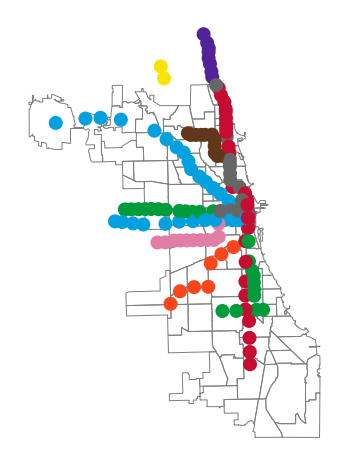

In [100]:
#plot these for sanity check
fig, ax = plt.subplots()

gdf_neigh.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5,aspect=1)

gdf_routes.plot(ax=ax, categorical=True,
                color=gdf_routes["color"],# color by line name
)
ax.set_axis_off()
plt.show()


Data and shape and identification looks good. We'll digress for a minute to get these to plot as connected lines....

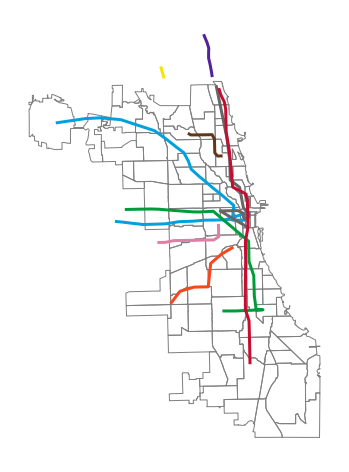

In [101]:
from shapely.ops import unary_union, linemerge, snap
from shapely.geometry import LineString, MultiLineString, MultiPoint

def _collect_points(geom):
    """Collect Points from any geometry into a MultiPoint."""
    if geom is None or geom.is_empty:
        return MultiPoint([])
    pts = []
    if hasattr(geom, "geoms"):
        for g in geom.geoms:
            if g.geom_type == "Point":
                pts.append(g)
            elif g.geom_type == "MultiPoint":
                pts.extend(list(g.geoms))
            elif hasattr(g, "geoms"):  # collection: recurse
                pts_geom = _collect_points(g)
                pts.extend(list(pts_geom.geoms))
    elif geom.geom_type == "Point":
        pts = [geom]
    elif geom.geom_type == "MultiPoint":
        pts = list(geom.geoms)
    return MultiPoint([p for p in pts if p.is_valid])

def _multipoint_to_linestring(mp: MultiPoint) -> LineString | None:
    """Heuristic: build a LineString visiting all points. Returns None if <2 points."""
    if mp is None or mp.is_empty or len(mp.geoms) < 2:
        return None
    # simple greedy NN path from one extreme point (farthest pair)
    import numpy as np
    coords = [p.coords[0] for p in mp.geoms]
    X = np.array(coords)
    d2 = ((X[:, None, :] - X[None, :, :]) ** 2).sum(axis=2)
    i0, _ = np.unravel_index(d2.argmax(), d2.shape)
    order = [i0]
    remaining = set(range(len(coords))) - {i0}
    cur = i0
    while remaining:
        nxt = min(remaining, key=lambda k: d2[cur, k])
        order.append(nxt); remaining.remove(nxt); cur = nxt
    path = [coords[i] for i in order]
    # guard zero-length
    if len(path) < 2 or path[0] == path[-1] and len(set(path)) == 1:
        return None
    return LineString(path)

# keep what's needed and normalize to single-part lines
gdf = gdf_routes[["line_color", "geometry"]].explode(index_parts=False, ignore_index=True)

rows = []
for route, grp in gdf_routes.groupby("line_color", dropna=False):
    geom = unary_union(grp.geometry.values)

    #build a line from points
    mp = _collect_points(geom)
    ln = _multipoint_to_linestring(mp)
    if ln is not None and ln.length > 0:
        lines = [ln]
        
    # lines = [...]  # your list of LineStrings for this route (drop zero-length)
    mls = MultiLineString(lines)
    
    merged = linemerge(mls)   # safe: input is always MultiLineString
    # merged = linemerge(unary_union(lines))  # may be LineString or MultiLineString
    rows.append({"line_color": route, "geometry": merged})
    
glines = gpd.GeoDataFrame(rows, crs=gdf.crs)
glines["color"] = glines["line_color"].map(CTA_COLORS).fillna("#666666")  # gray fallback

#plot these again to check
fig, ax = plt.subplots()
gdf_neigh.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5,aspect=1)
glines.plot(ax=ax, categorical=True,color=glines["color"])
ax.set_axis_off()
plt.show()


Okay, definitely still some confusion due to the loop being designated as multi-line but this does give us an idea still. Now that we have all of the pieces, let's see what we can learn

In [102]:
# Project to meters for distance calculation
gdf_cta_proj = gdf_cta.to_crs(epsg=3857)
gdf_routes_proj = gdf_routes.to_crs(epsg=3857)


In [103]:
# Find nearest CTA line for each crime
nearest = gpd.sjoin_nearest(gdf_cta_proj, gdf_routes_proj, how="left", distance_col="dist")

In [104]:
routes = gdf_routes_proj[['line_color', "geometry"]].dropna(subset=["geometry"]).copy()

# produces one MultiLineString per line
routes = routes.dissolve(by='line_color', as_index=False)

#merge back in the nearest_line 
gdf_cta["nearest_line"] = nearest['line_color'].values
gdf_cta["dist_to_line_m"] = nearest["dist"].values

#but keep only crimes within 100m
gdf_cta = gdf_cta[gdf_cta["dist_to_line_m"]<=100]

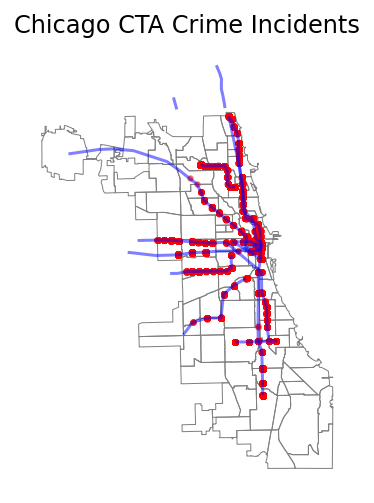

In [105]:
# plot everything together
fig, ax = plt.subplots()
gdf_neigh.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5,aspect=1)
glines.plot(ax=ax, categorical=True,color="blue", alpha=0.5)

gdf_cta.plot(ax=ax, markersize=5, color="red", alpha=0.5, label="CTA Crimes")

plt.title("Chicago CTA Crime Incidents")
ax.set_axis_off()
# plt.legend()
plt.show()


In [106]:
# Drop crimes that couldn't be matched
agg_data = gdf_cta.dropna(subset=["nearest_line"])

# Count crimes per year, line, and category
line_counts = (
    agg_data.groupby(["year", "nearest_line", "crime_category"])
    .size()
    .reset_index(name="count")
)
line_counts.head()


,year,nearest_line,crime_category,count
0,2001,BLUE,Petty,149
1,2001,BLUE,Violent,66
2,2001,BROWN,Petty,48
3,2001,BROWN,Violent,14
4,2001,GREEN,Petty,167


Text(0.5, 1.0, 'Crime Trends on CTA Train Lines (2001–Present)')

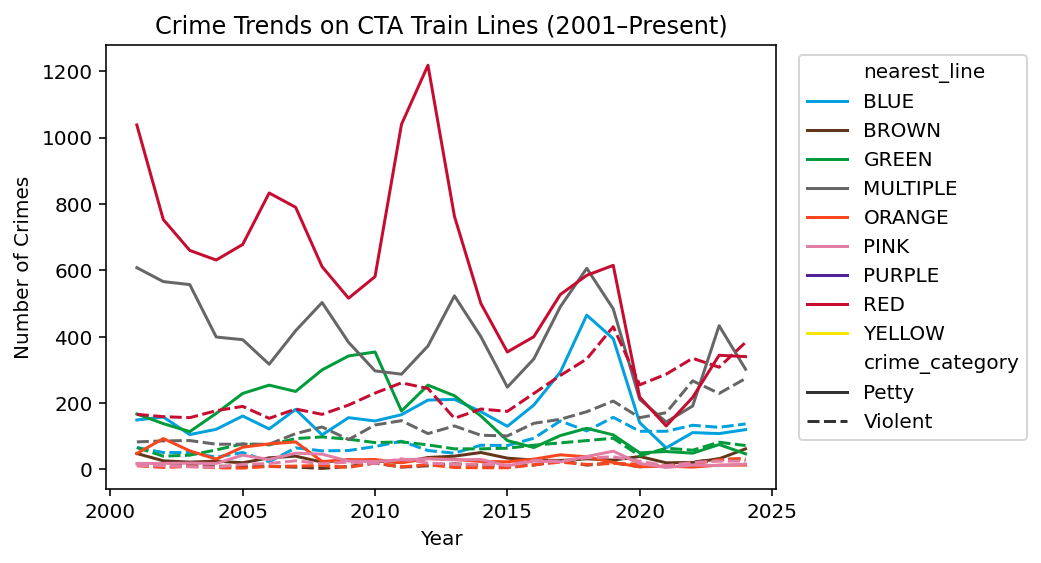

In [107]:
#crime trends on all the lines (ignore 2025 as it isn't a full year, so misleading)
sns.lineplot(data=line_counts[line_counts['year']<=2024],x='year', y='count',style='crime_category',
             hue='nearest_line',hue_order=CTA_ORDER,palette=cta_palette)
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.legend(bbox_to_anchor=(1.02, 1), loc='best')
plt.title("Crime Trends on CTA Train Lines (2001–Present)")

Let's take a look at the location of the crimes occurring in the overlap of the lines (aka Multiple). I'm assuming that is near the loop but let's check.

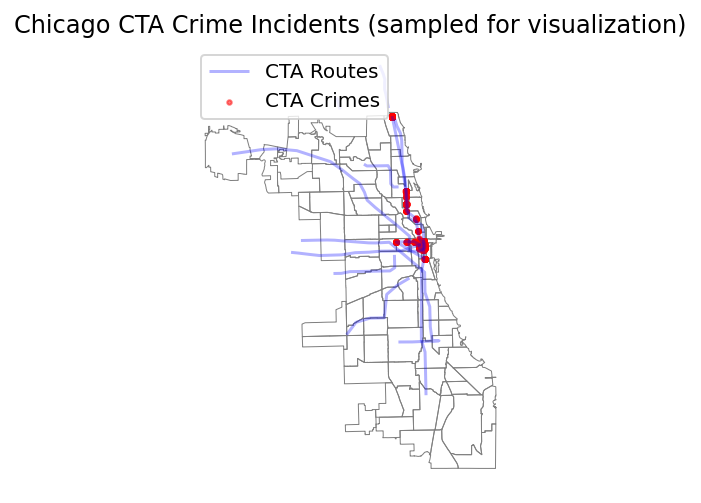

In [108]:
# plot everything together
fig, ax = plt.subplots()

gdf_neigh.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5,aspect=1)
glines.plot(ax=ax, categorical=True,color="blue", alpha=0.3, label="CTA Routes",aspect=1)

gdf_cta[gdf_cta["nearest_line"]=="MULTIPLE"].sample(1000).plot(ax=ax, markersize=5, color="red", alpha=0.5, label="CTA Crimes")

plt.title("Chicago CTA Crime Incidents (sampled for visualization)")
ax.set_axis_off()
plt.legend()
plt.show()

Okay, yes these seem clustered near the loop with some in the overlap of purple/brown/red and even the green/blue overlap. Good to know.

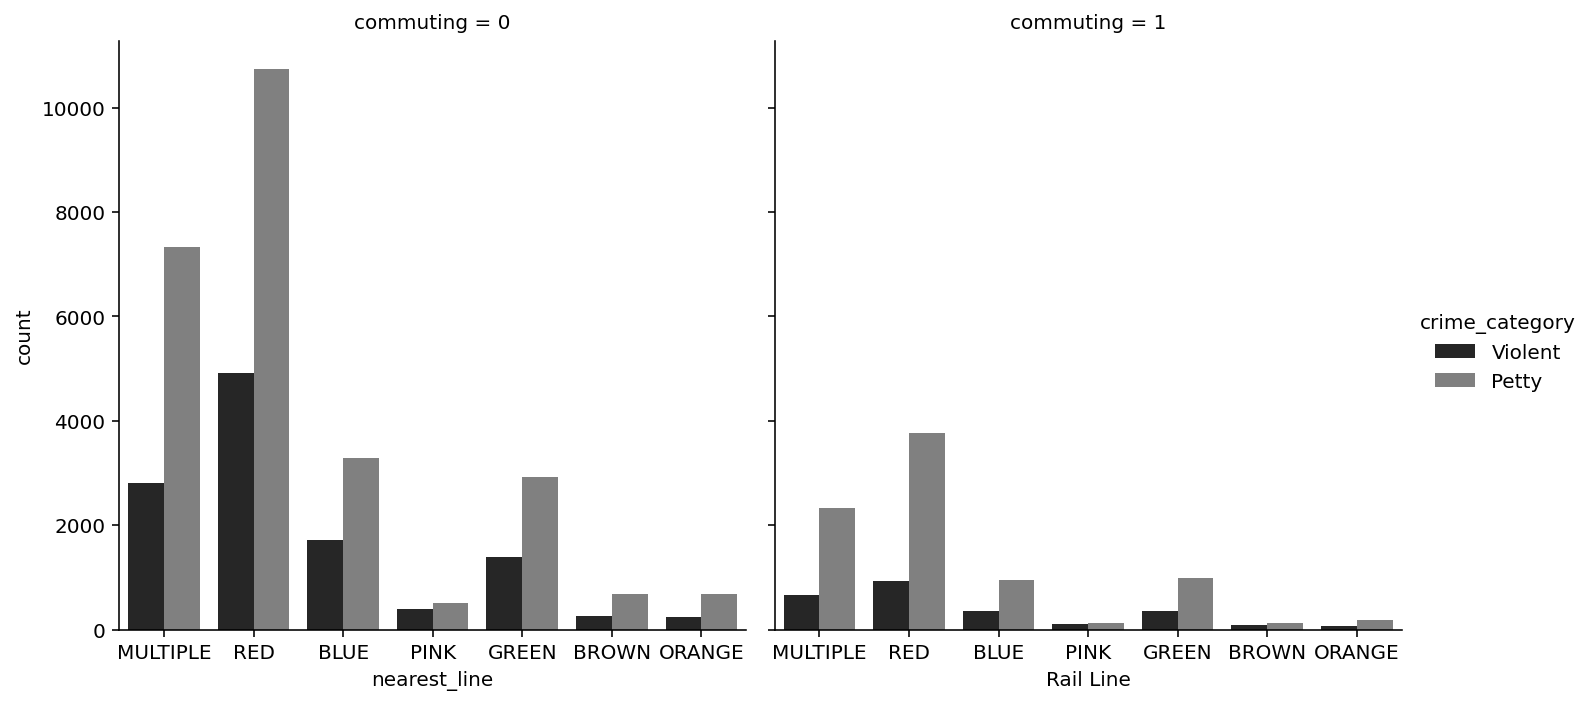

In [109]:
sns.catplot(data=gdf_cta, kind='count', x='nearest_line',hue='crime_category',col='commuting',palette='dark:grey',hue_order=['Violent','Petty'])
plt.xlabel("Rail Line")
plt.ylabel("Number of Crimes")
plt.show()


While the line to line comparison is interesting, this still isn't truly representative because the line lengths differ significantly (e.g. the Brown line is short). Also, as we checked, "Multiple Lines" is designated at a station of overlap, such as the loop, so interesting that the majority of those events are still related or adjacent to the Red or Blue lines which are already the highest other categories.

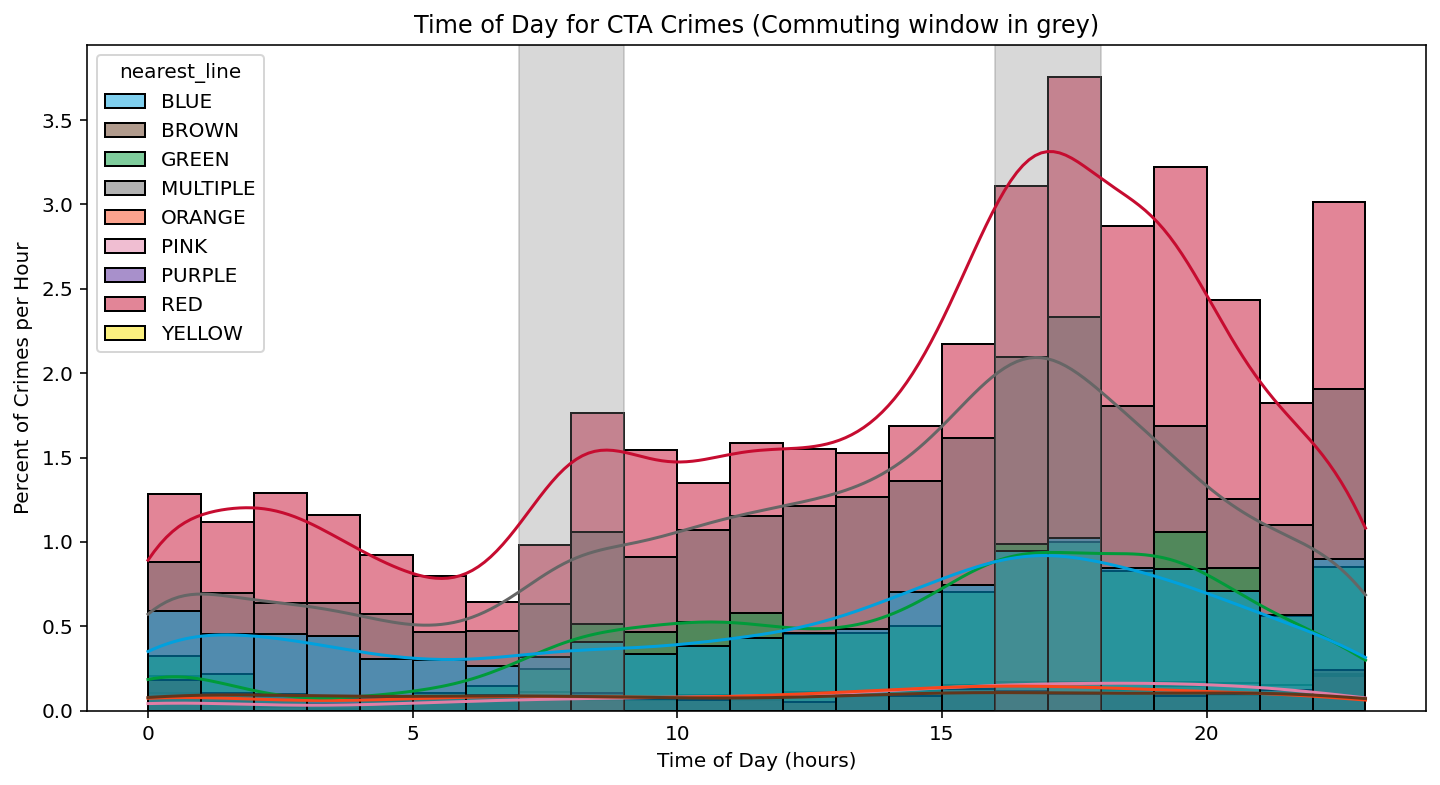

In [110]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=gdf_cta, x=gdf_cta['date'].dt.hour,binwidth=1,
             hue='nearest_line',hue_order=CTA_ORDER,palette=cta_palette, stat='percent', kde=True) #.dt.dayofweek

# Add highlighting of commuting windows
ax.axvspan(7, 9, color='grey', alpha=0.3, label='Commuting')
ax.axvspan(16, 18, color='grey', alpha=0.3, label='Commuting')

plt.ylabel("Percent of Crimes per Hour")
plt.xlabel("Time of Day (hours)")
plt.title('Time of Day for CTA Crimes (Commuting window in grey)')
plt.show()

Now let's load the ridership data from: https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data and adjust so that we are looking at the rate of crimes relative to ridership (we only have totals for weekdays, weekends, and holidays within a month so the greatest granularity we will have for a rate is per month.

In [111]:
RIDES = "data/CTA_Average_Rail_Station_Ridership_1999_2025.csv"   # 'L' Station Entries - Daily Totals
STATIONS = "data/CTA_RAIL_STATIONS.zip"   # List of 'L' Stops (booleans per line)

#Station ridership (sum TOTAL_RIDES)
rides_raw = pd.read_csv(RIDES)
rides = (rides_raw.rename(columns={"RIDERSHIP_ID":"station_id","YEAR":"year","MONTH":"month","TOTAL_RIDES":"TOTAL_RIDES"})
        .assign(station_id=lambda d: pd.to_numeric(d["station_id"], errors="coerce").astype("Int64"),
            Year=lambda d: pd.to_numeric(d["year"], errors="coerce").astype("Int64"),
            Month=lambda d: pd.to_numeric(d["month"], errors="coerce").astype("Int64"),
            TOTAL_RIDES=lambda d: pd.to_numeric(d["TOTAL_RIDES"], errors="coerce").fillna(0)
        )
         .dropna(subset=["station_id","year"]))
rides_station_month = (rides.groupby(["station_id", "year", "month"], as_index=False)["TOTAL_RIDES"].sum()
                             .rename(columns={"TOTAL_RIDES": "rides"}))
rides_station_month["date"] = pd.to_datetime(dict(year=rides_station_month["year"].astype(int),
                                            month=rides_station_month["month"].astype(int),
                                            day=1))

rides_station_year = (rides.groupby(["station_id","year"], as_index=False)["TOTAL_RIDES"]
                           .sum().rename(columns={"TOTAL_RIDES":"rides"}))

# Station → line(s) via LEGEND codes in the stations layer
g = gpd.read_file(f"zip://{STATIONS}")
legend_map = {"BL":"BLUE","BR":"BROWN","GR":"GREEN",
              "OR":"ORANGE","PK":"PINK","PR":"PURPLE",
              "RD":"RED","YL":"YELLOW","ML":"MULTIPLE"}
st = g[["STATION_ID","LEGEND"]].copy()
st["STATION_ID"] = pd.to_numeric(st["STATION_ID"], errors="coerce").astype("Int64")
st["line_token"] = st["LEGEND"].astype(str).str.upper().map(legend_map)

MULTI_LINES = ["RED","BLUE","BROWN","GREEN","ORANGE","PINK","PURPLE"]  # ML approximation
rows = []
for _, r in st.dropna(subset=["STATION_ID","line_token"]).iterrows():
    sid = int(r["STATION_ID"]); tok = r["line_token"]
    if tok == "MULTI":
        rows += [{"station_id": sid, "line": t} for t in MULTI_LINES]
    else:
        rows.append({"station_id": sid, "line": tok})
map_df = pd.DataFrame(rows).drop_duplicates()

# Merge & apportion shared stations across their lines
m = rides_station_month.merge(map_df, on="station_id", how="inner")
n = (m.groupby(["station_id","date"]).size().rename("n_lines").reset_index())
m = m.merge(n, on=["station_id","date"], how="left")
m["rides_share"] = m["rides"] / m["n_lines"].clip(lower=1)

ridership_by_line_month = (m.groupby(["year","month","line"], as_index=False)["rides_share"]
                            .sum().rename(columns={"rides_share":"rides"})
                            .sort_values(["year","month","line"]))
ridership_by_line_month.head()
# ridership_by_line_year = (m.groupby(["Year","line"], as_index=False)["rides_share"]
#                             .sum().rename(columns={"rides_share":"rides"})
#                             .sort_values(["Year","line"]))



,year,month,line,rides
0,1999,1,BLUE,2342106.0
1,1999,1,BROWN,546606.0
2,1999,1,GREEN,613078.0
3,1999,1,MULTIPLE,1968326.0
4,1999,1,ORANGE,505718.0


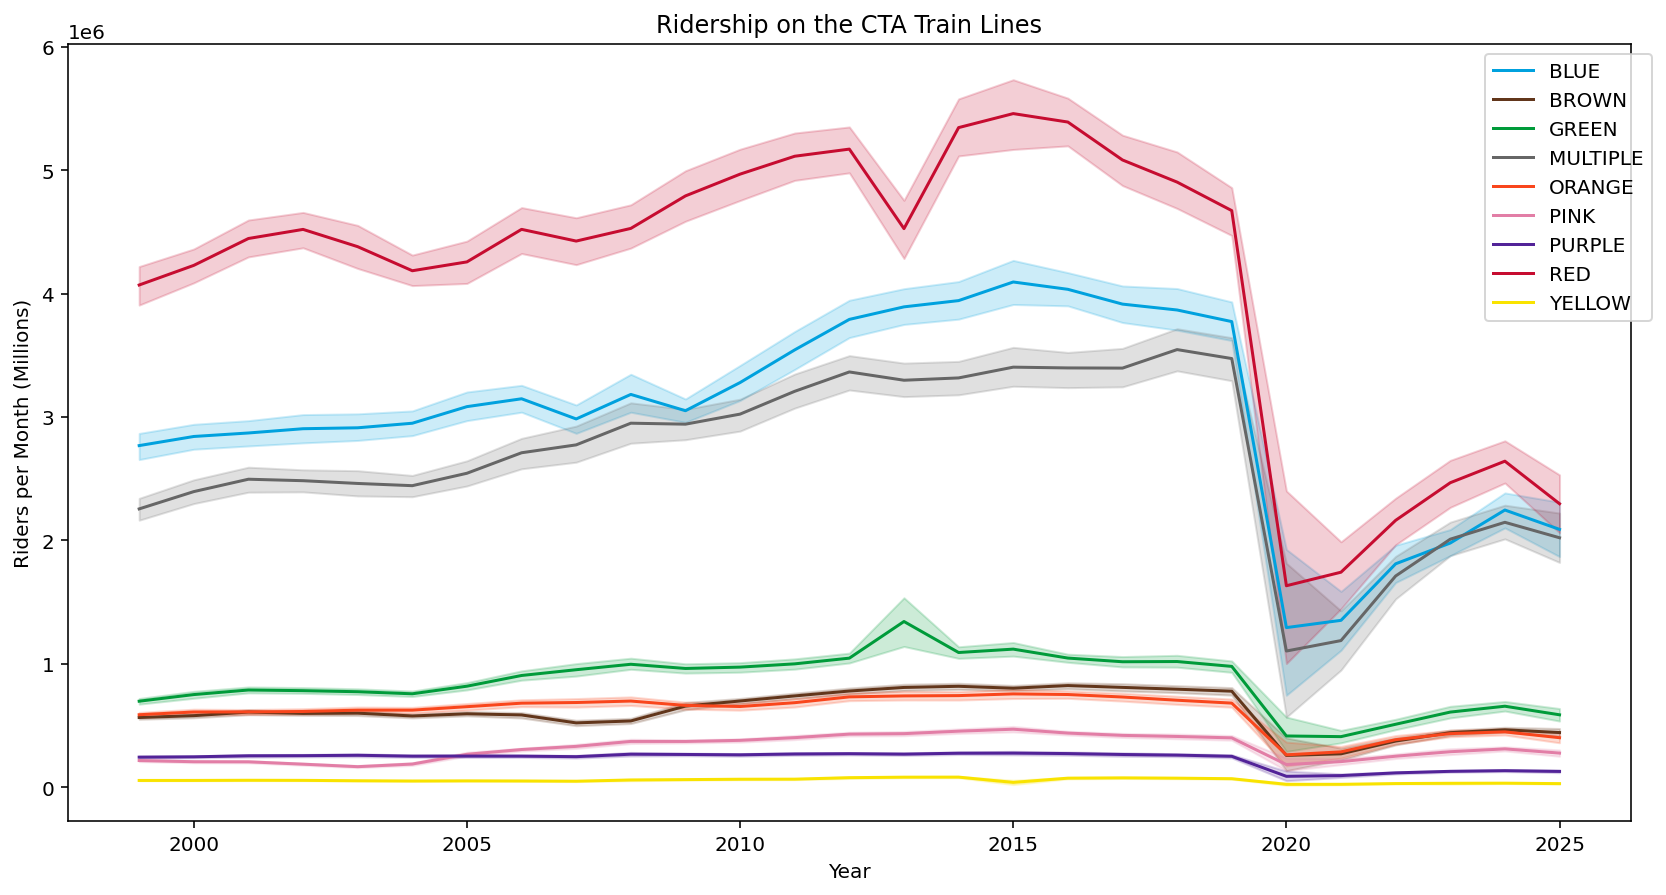

In [112]:
plt.figure(figsize=(14,7))
sns.lineplot(data=ridership_by_line_month,x='year', y='rides',hue='line',
             hue_order=CTA_ORDER,palette=cta_palette)

plt.title("Ridership on the CTA Train Lines")
plt.ylabel("Riders per Month (Millions)")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.02, 1), loc='best')
plt.show()

A lot has changed post-pandemic. Ridership is still down from pre-pandemic levels, people work from home more, neighborhoods were reshaped, etc.

In [113]:
#now merge with the crime data to get a rate of crimes
#crime data doesn't start until 2001
cta_rides = ridership_by_line_month[(ridership_by_line_month['year'] >= 2001)]

crimes = gdf_cta.groupby(['year','month','crime_category','nearest_line'])['crime_category'].count().reset_index(name='count')

crimes.rename(columns={'nearest_line': 'line'}, inplace=True)
crime_rate = pd.merge(crimes,cta_rides, on=['year','month','line'], how='inner')
crime_rate['rate_pM'] = crime_rate['count']/(crime_rate['rides']/1000000)
crime_rate.head()
                         

,year,month,crime_category,line,count,rides,rate_pM
0,2001,1,Petty,BLUE,15,2782523.0,5.390791
1,2001,1,Petty,BROWN,4,605131.0,6.610139
2,2001,1,Petty,GREEN,15,767215.0,19.551234
3,2001,1,Petty,MULTIPLE,93,2474007.0,37.590839
4,2001,1,Petty,ORANGE,2,592022.0,3.378253


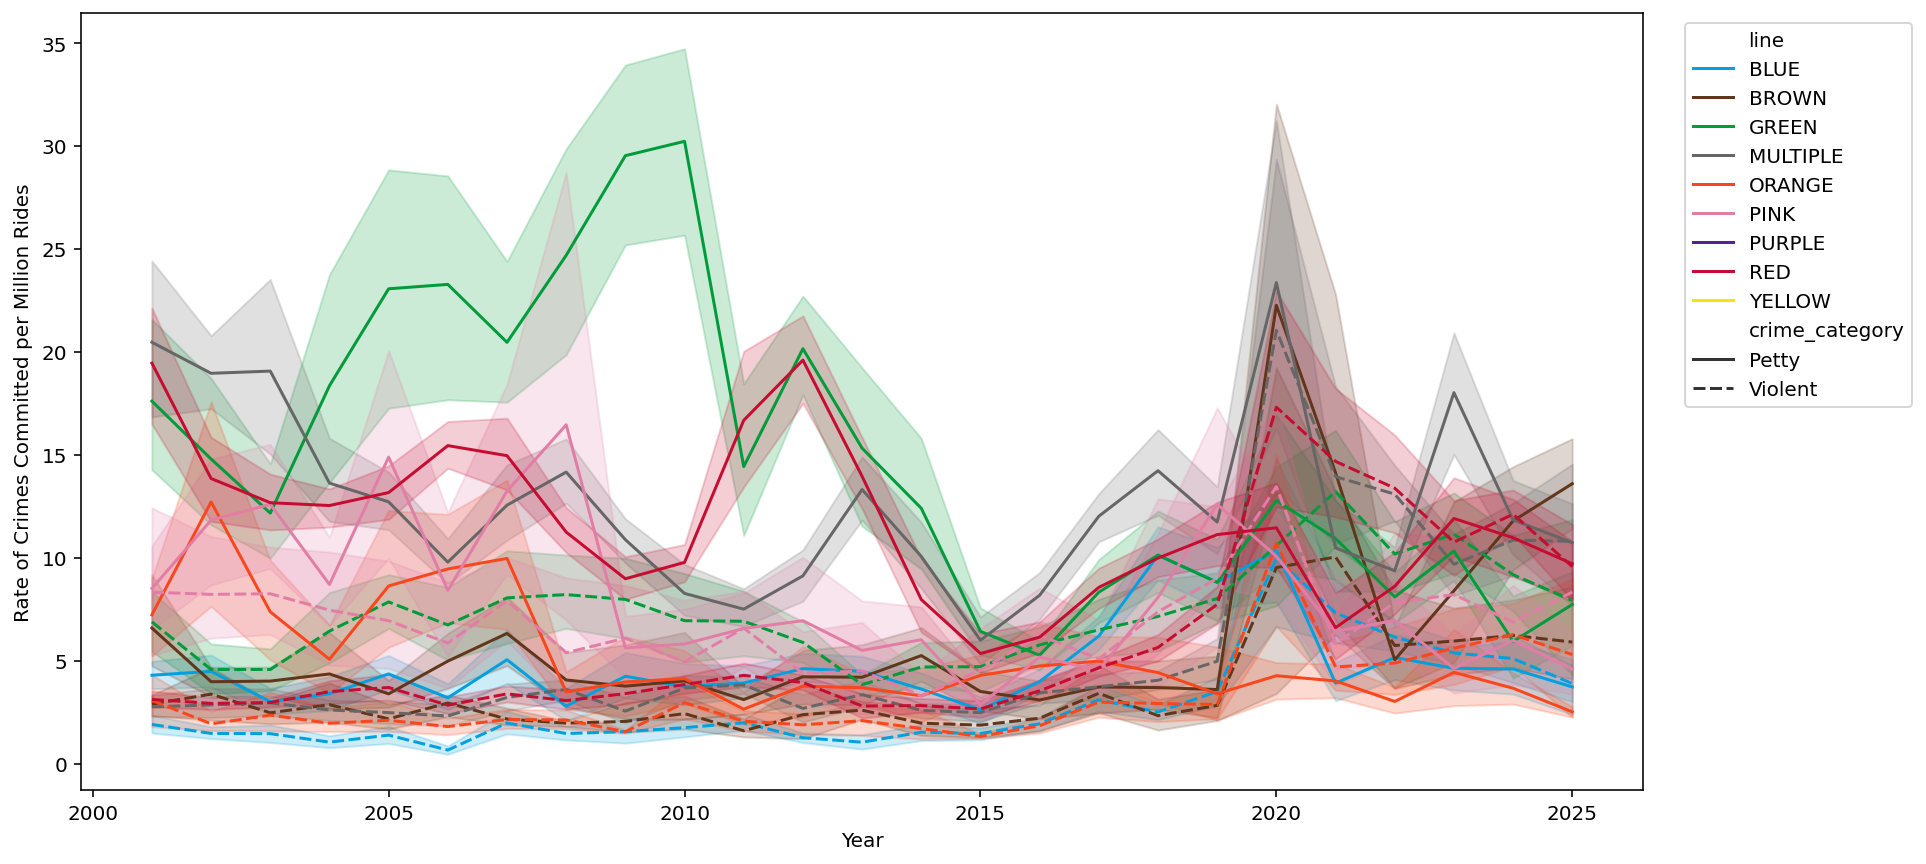

In [114]:
plt.figure(figsize=(14,7))
sns.lineplot(data=crime_rate,x='year', y='rate_pM',hue='line',style='crime_category',
             hue_order=CTA_ORDER,palette=cta_palette)

plt.ylabel("Rate of Crimes Committed per Million Rides")
plt.xlabel("Year")
plt.legend(bbox_to_anchor=(1.02, 1), loc='best')
plt.show()

The crime rate on the Green line matches its reputation (outpacing even the much more heavily used Red line), but it does seem like it was shifting and had dropped by 2015. Would be interesting to dig more into what might have contributed to that but it is a possible sign of the gentrification throughout the West side of the city.

Let's zoom in on just the post-pandemic years since we know ridership was significantly affected by that. We won't count 2025 since it isn't a full year, so we only have 3 years (2022-2024) to pull post and will pull the same for pre- (2017-2019).

In [115]:
post_crime_rate = crime_rate.loc[(crime_rate['year'] >= 2022) & (crime_rate['year'] <= 2024)] 
pre_crime_rate = crime_rate.loc[(crime_rate['year'] >= 2017) & (crime_rate['year'] <= 2019)] 

pre_crime_rate = pre_crime_rate.assign(time='pre')
post_crime_rate = post_crime_rate.assign(time='post')
df_test = pd.concat([pre_crime_rate, post_crime_rate], ignore_index=True)

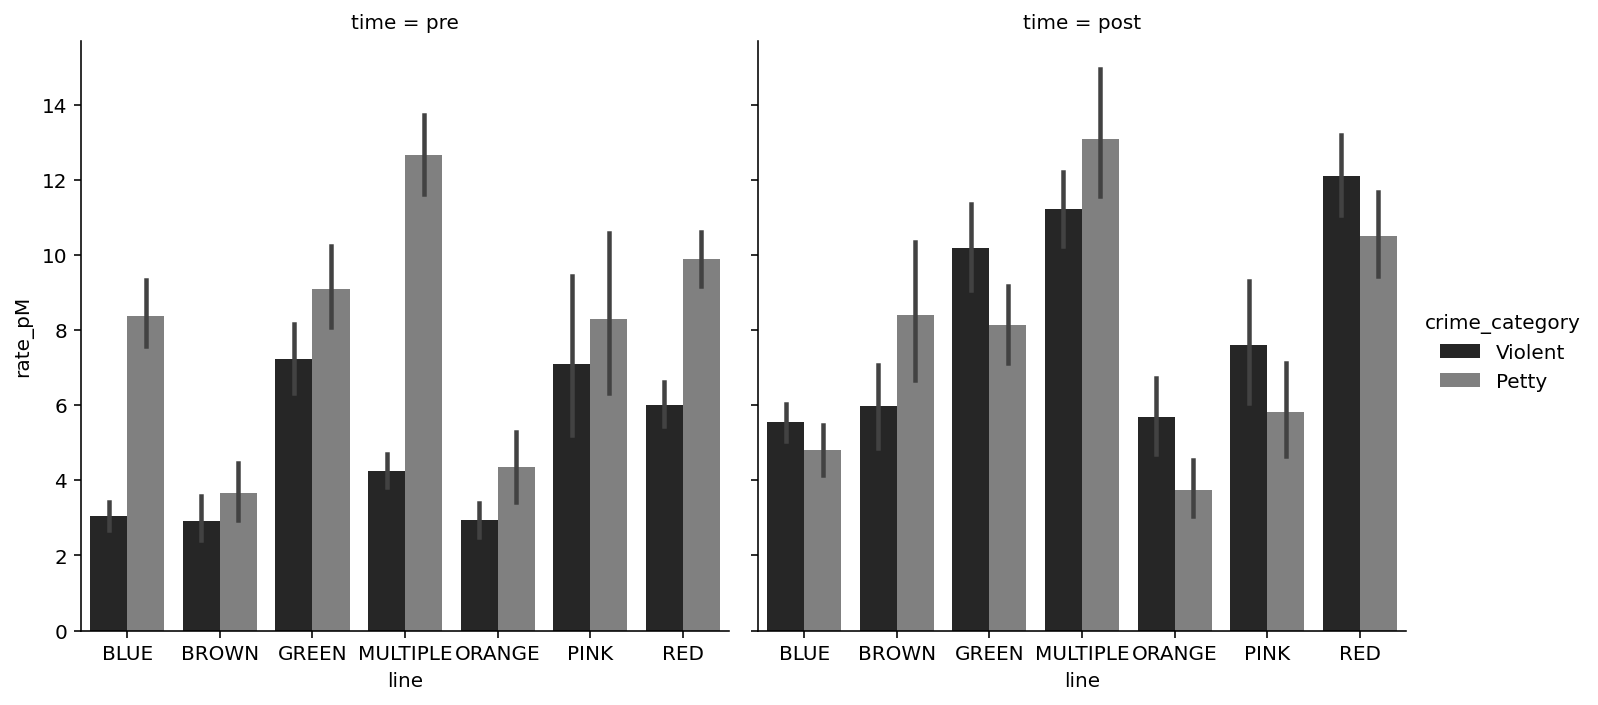

In [116]:

sns.catplot(data=df_test, kind='bar',x='line',y='rate_pM',col='time', hue='crime_category',palette='dark:grey',hue_order=['Violent','Petty'])
plt.ylabel("Rate of Crimes Committed per Million Rides")
plt.show()

Interesting that Violoent crimes are starting to overtake the rate of the Petty crimes. Violent crimes seem to be worse than the rate in pre-pandemic years but it is hard to tell if there is a definite shift in th Petty crime rate. Let's model this to test it

In [117]:
f = "rate_pM ~ time * C(crime_category) + month"

# Fit Poisson GLM with log link and offset
model = smf.glm(formula=f, data=df_test,
                family=sm.families.Poisson())
res = model.fit(cov_type="HAC", cov_kwds={"maxlags": 12})  # monthly HAC

res.summary()
# poisson_diagnostics(res, df=df_test)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                rate_pM   No. Observations:                  935
Model:                            GLM   Df Residuals:                      930
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2787.0
Date:                Mon, 08 Sep 2025   Deviance:                       2128.9
Time:                        20:15:34   Pearson chi2:                 2.34e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2744
Covariance Type:                  HAC                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    2.1891      0.058     37.670      0.000       2.075       2.303
time[T.pre]                                  0.0094      0.050      0.187      0.852      -0.089       0.108
C(crime_category)[T.Violent]                 0.0357      0.049      0.729      0.466      -0.060       0.132
time[T.pre]:C(crime_category)[T.Violent]    -0.5437      0.069     -7.935      0.000      -0.678      -0.409
month                                       -0.0147      0.006     -2.369      0.018      -0.027      -0.003
============================================================================================================
"""

So accross all lines and crime category rates there has not been significant changes pre to post. However, Violent crimes are ~42% more prevalanet prior to the pandemic. So this matches what we were seeing visually and confirms this is a pretty big shift. Let's visualize this a different way that more directly matches what we tested.

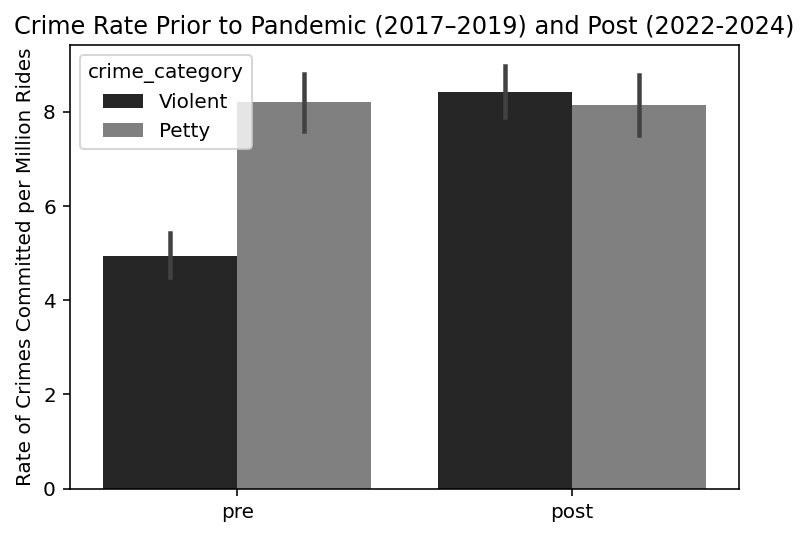

In [118]:
ax = sns.barplot(data =df_test,x='time', y='rate_pM',hue='crime_category',palette='dark:grey',hue_order=['Violent','Petty'])
plt.ylabel("Rate of Crimes Committed per Million Rides")
plt.xlabel(None)
plt.title("Crime Rate Prior to Pandemic (2017–2019) and Post (2022-2024)")
plt.show()

Okay, now that we have a sense of the data, let's save this off for ML use 

In [119]:
import pyarrow
gdf_cta.to_parquet("cta_crimes.parquet", index=False) 
ridership_by_line_month.to_parquet("cta_riders_month.parquet", index=False) 
